# Logistic Regression with Bag of Words

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

tqdm.pandas() # To use progress_apply and better visualize the progress

from notebooks.models.tokenizers import CustomTokenizer

In [2]:
# Load dataset.csv into a pandas dataframe
df = pd.read_csv('../data/dataset.csv', index_col=0)

# Shuffle dataset
df = df.sample(frac=1)

df.head()

,id,url,title,text,category
45983,9658834,https://en.wikipedia.org/wiki/Musya,Musya,is a 1992 platform game developed by Jorudan f...,video games
164204,53728891,https://en.wikipedia.org/wiki/Angochitina,Angochitina,Angochitina is an extinct genus of chitinozoan...,animals
96396,27194591,https://en.wikipedia.org/wiki/Savings%20Deposi...,Savings Deposit Insurance Fund of Turkey,The Savings Deposit Insurance Fund of Turkey (...,finance
34027,5816080,https://en.wikipedia.org/wiki/%C5%81ukasz%20Zb...,Łukasz Zbonikowski,Łukasz Zbonikowski (born 20 February 1978 in T...,politicians
46070,9695957,https://en.wikipedia.org/wiki/Silver%20lamprey,Silver lamprey,The silver lamprey (Ichthyomyzon unicuspis) is...,animals


## Bag of Words


In [3]:
size = 10_000

In [4]:
X = df['text'][:size]
y = df['category'][:size]

X.head()

45983     is a 1992 platform game developed by Jorudan f...
164204    Angochitina is an extinct genus of chitinozoan...
96396     The Savings Deposit Insurance Fund of Turkey (...
34027     Łukasz Zbonikowski (born 20 February 1978 in T...
46070     The silver lamprey (Ichthyomyzon unicuspis) is...
Name: text, dtype: object

In [5]:
# We use the custom tokenizer and remove stopwords
tokenizer = CustomTokenizer(remove_stopwords=True)

X_encoded = X.progress_apply(tokenizer.encode)

X_encoded.head()

100%|██████████| 10000/10000 [00:05<00:00, 1702.45it/s]


45983     [2550, 17, 5452, 1847, 8040, 503, 269, 664, 27...
164204    [526, 5059, 275, 2259, 69918, 64677, 523, 275,...
96396     [82, 46851, 16946, 8276, 3887, 45405, 39204, 2...
34027     [4697, 3178, 53440, 1167, 6098, 1609, 29384, 3...
46070     [83014, 29062, 8233, 320, 718, 27520, 5650, 52...
Name: text, dtype: object

In [6]:
# We get the vocabulary
vocab = set()

for tokens in tqdm(X_encoded):
    for token in tokens:
        vocab.add(token)

vocab_size = len(vocab)
vocab_size

100%|██████████| 10000/10000 [00:00<00:00, 19324.98it/s]


42762

In [7]:
# We create the bag of words

X_encoded = X_encoded.to_frame() 
X_encoded['bow'] = pd.Series(dtype='object')

def create_bow(tokens):
    bow = {}
    for token in tokens:
        if token in bow:
            bow[token] += 1
        else:
            bow[token] = 1
    return bow

X_encoded['bow'] = X_encoded['text'].progress_apply(lambda x: create_bow(x))

X_encoded.head()

100%|██████████| 10000/10000 [00:00<00:00, 17336.43it/s]


,text,bow
45983,"[2550, 17, 5452, 1847, 8040, 503, 269, 664, 27...","{2550: 4, 17: 4, 5452: 2, 1847: 9, 8040: 2, 50..."
164204,"[526, 5059, 275, 2259, 69918, 64677, 523, 275,...","{526: 1, 5059: 1, 275: 3, 2259: 4, 69918: 1, 6..."
96396,"[82, 46851, 16946, 8276, 3887, 45405, 39204, 2...","{82: 1, 46851: 1, 16946: 3, 8276: 4, 3887: 2, ..."
34027,"[4697, 3178, 53440, 1167, 6098, 1609, 29384, 3...","{4697: 1, 3178: 2, 53440: 2, 1167: 2, 6098: 2,..."
46070,"[83014, 29062, 8233, 320, 718, 27520, 5650, 52...","{83014: 1, 29062: 27, 8233: 21, 320: 7, 718: 3..."


## Format the data to be used in PyTorch

In [8]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

integer_encoded

array([17,  1,  6, ..., 18,  8,  7])

In [9]:
# We first need to change the bag of words to a vector so that we can transform it to a tensor
vocab_list = list(vocab)
word_to_index = {word: index for index, word in enumerate(vocab_list)}

def bow_to_vector(bow):
    vector = np.zeros(vocab_size)
    for word, count in bow.items():
        index = word_to_index[word]
        vector[index] = count
    return vector

X_vector = X_encoded['bow'].progress_apply(bow_to_vector)

X_vector.head()

100%|██████████| 10000/10000 [00:03<00:00, 3084.25it/s]


45983     [0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...
164204    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...
96396     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
34027     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
46070     [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, ...
Name: bow, dtype: object

In [10]:
# Convert to PyTorch tensors

X = np.array(X_vector.tolist()) # Convert to numpy array

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_tensor.shape, y_tensor.shape

(torch.Size([10000, 42762]), torch.Size([10000]))

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Logistic Regression Model

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
#model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

LogisticRegressionModel(
  (linear): Linear(in_features=42762, out_features=20, bias=True)
)
Epoch [1/20], Loss: 2.2702
Precision: 0.7955, Recall: 0.7815, F1 Score: 0.7806
Epoch [2/20], Loss: 0.2209
Precision: 0.8039, Recall: 0.7825, F1 Score: 0.7856
Epoch [3/20], Loss: 0.0172
Precision: 0.8128, Recall: 0.8105, F1 Score: 0.8095
Epoch [4/20], Loss: 0.0523
Precision: 0.8167, Recall: 0.8155, F1 Score: 0.8137
Epoch [5/20], Loss: 0.0295
Precision: 0.8184, Recall: 0.8180, F1 Score: 0.8159
Epoch [6/20], Loss: 0.0111
Precision: 0.8200, Recall: 0.8195, F1 Score: 0.8172
Epoch [7/20], Loss: 0.0060
Precision: 0.8153, Recall: 0.8150, F1 Score: 0.8129
Epoch [8/20], Loss: 0.0044
Precision: 0.8172, Recall: 0.8170, F1 Score: 0.8147
Epoch [9/20], Loss: 0.0067
Precision: 0.8166, Recall: 0.8165, F1 Score: 0.8141
Epoch [10/20], Loss: 0.0064
Precision: 0.8167, Recall: 0.8170, F1 Score: 0.8145
Epoch [11/20], Loss: 0.0040
Precision: 0.8157, Recall: 0.8160, F1 Score: 0.8134
Epoch [12/20], Loss: 0.0046
Precisio

## Confusion Matrix

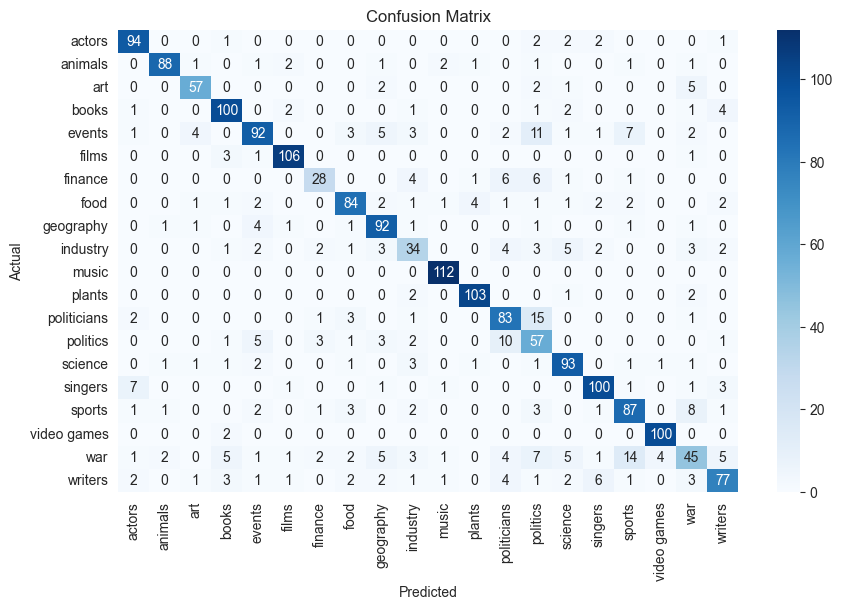

In [13]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_predictions.extend(predicted)
        
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()